![MIoT_GDPI](img/MIOT_GDPI_header.png)

# Unidad 03- Operaciones comunes en Stream Learning II - Concept Drift

El objetivo principal de esta práctica es que profundizar en las operaciones comunes de River para la carga y procesado de datos, así como introducir el *concept drift* y los métodos disponibles en River para poder detectarlo.

La mayor parte del contenido de este Notebook se dedica a explicar el uso de los comandos y de su integración en un *pipeline* apoyándose en ejemplos concretos que ilustran su aplicación a un problema real. Es crucial que dediquéis tiempo a leer y comprender el material, en lugar de simplemente ejecutar el código. Os invitamos a experimentar modificando y variando el código proporcionado para que podáis explorar las distintas opciones y profundizar en su funcionamiento.



**Importante**: El Notebook contiene varios ejercicios sencillos. Deberéis desarrollarlos durante la clase y enviarlos por el aula virtual del curso, en la tarea correspondiente.



## Referencias útiles para la práctica
1. Api River: [https://riverml.xyz](https://riverml.xyz)
2. Bahri, M., Bifet, A., Gama, J., Gomes, H. M., & Maniu, S. (2021). [Data stream analysis: Foundations, major tasks and tools](https://doi.org/10.1002/widm.1405). Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery, 11(3), e1405.
3. Gomes, H. M., Read, J., Bifet, A., Barddal, J. P., & Gama, J. (2019). [Machine learning for streaming data: state of the art, challenges, and opportunities](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://kdd.org/exploration_files/3._CR_7._Machine_learning_for_streaming_data_state_of_the_art-Final.pdf). ACM SIGKDD Explorations Newsletter, 21(2), 6-22.
4. Gama, J., Žliobaitė, I., Bifet, A., Pechenizkiy, M., & Bouchachia, A. (2014). [A survey on concept drift adaptation](https://dl.acm.org/doi/10.1145/2523813). ACM computing surveys (CSUR), 46(4), 1-37.
5.  Lu, J., Liu, A., Dong, F., Gu, F., Gama, J., & Zhang, G. (2018). [Learning under concept drift: A review](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8496795). IEEE Transactions on Knowledge and Data Engineering, 31(12), 2346-2363.

## 1. Lectura de datos desde fichero


Cuando trabajamos con aprendizaje incremental, esperamos que los datos lleguen y sean procesados por nuestro modelo como un flujo continuo pero es típico que tengamos que trabajar con flujos proactivos (observaciones contenidas en ficheros) durante el desarrollo de  nuestro modelo base antes de desplegarlo en un entorno de producción. 
En las unidades anteriores empleamos conjuntos de datos ya incluidos en la librería River, lo que facilitaba el desarrollo y entendimiento del proceso pero, la realidad, es que normalmente necesitamores cargar nuestros propios *datasets*. River proporciona diferentes conectores para obtener datos de diferentes tipos de fuentes como, por ejemplo, archivos CSV. Para crear un flujo de datos proactivo a partir de estos archivos, los conectores de River producen objetos generadores que, cuando se utilizan a través de un iterador, actúan como secuencias de datos que nos permiten  alimentar nuestros modelos incrementales. 
En este ejemplo, emplearemos datos contenidos en un archivo CSV y aprenderemos a cargarlos y procesarlos. Para realizarlo utilizaremos el *dataset* del Titanic que se  puede descargar desde [Kaggle](https://www.kaggle.com/c/titanic/data). Aunque el problema del Titanic no es el apropiado para un procesamiento incremental, es suficientemente claro y conocido para facilitar el entendimiento del proceso de carga de datos en River. Es importante destacar que el objetivo es aprender a cargar y procesar las observaciones,  por lo que la precisión y el rendimiento del modelo son secundarios.
Se podrían realizar diferentes operaciones de preprocesamiento que mejorasen el rendimiento de un modelo para predecir las probabilidades de supervivencia a bordo del Titanic pero, sin embargo,  este Notebook solo muestra algunas para demostrar cómo aplicar diferentes operaciones con River.



Aunque el paradigma  de aprendizaje incremental difiere del de aprendizaje por lotes (batch), aún sigue siendo necesario conocer la estructura de los datos de entrada para adaptarla a nuestro modelo. La estructura de datos del conjunto de datos del Titanic en forma de diccionario se puede encontrar en el repositorio de [Kaggle](https://www.kaggle.com/c/titanic/data).


### 1.1 Primer paso

Carga el dataset con Pandas y analiza los  campos y las características:

In [1]:
import pandas as pd
dataset_path="./datasets/titanic.csv" #Ajusta el path según tu directorio
data=pd.read_csv(dataset_path)
print(data.head())
print(data.dtypes)
print(data.describe())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
Pa


A pesar de que River tiene un conector para iterar sobre *DataFrames*, en este caso, por motivos docentes, emplearemos un [conector](https://riverml.xyz/latest/api/stream/iter-csv/) para trabajar sobre ficheros CSV

`iter_csv`genera un iterador de Python. Cada vez qye usamos `next` obtenemos una observación con sus *inputs* y *output* correspondiente.


In [2]:


from river import stream
from rich import print
titanic = stream.iter_csv(dataset_path)
sample, target = next(titanic)
print(sample)
print(target)



{
    'PassengerId': '1',
    'Survived': '0',
    'Pclass': '3',
    'Name': 'Braund, Mr. Owen Harris',
    'Sex': 'male',
    'Age': '22',
    'SibSp': '1',
    'Parch': '0',
    'Ticket': 'A/5 21171',
    'Fare': '7.25',
    'Cabin': '',
    'Embarked': 'S'
}

None

Fijaos en que el output es None. Esto ocurre porque, por defecto, no se puede determinar automáticamente qué atributos son inputs y cuáles son outputs. Es necesario especificarlo explícitamente.

In [3]:
titanic = stream.iter_csv(dataset_path, target="Survived")
sample, target = next(titanic)
print("###Inputs###")
for key, value in sample.items():
    print(f"{key}={value}")
print("###Targets###")
print(f"Superviviente: {target} - {'Sí' if target==1 else 'No'}")

###Inputs###

PassengerId=1

Pclass=3

Name=Braund, Mr. Owen Harris

Sex=male

Age=22

SibSp=1

Parch=0

Ticket=A/5 21171

Fare=7.25

Cabin=

Embarked=S

###Targets###

Superviviente: 0 - No

### 1.2. Carga de atributos categóricos (nominales) y numéricos.

Al utilizar un conector de River, por defecto, todos los atributos cargados se interpretan como cadenas de texto (atributos categóricos).Es necesario emplear el parámetro `converters` en `iter_csv` para modificar este comportamiento y asignar un tipo específico a cada atributo cargado, lo que se conoce como *casting*. Para decisiones de tipado más complejas, es posible emplear también funciones (*lambda*) para convertir los datos.
- *converters. Type → dict | None*: Por defecto, todos los valores del CSV se interpretan como cadenas de texto pero puedes usar este parámetro para convertir los valores al tipo deseado. Para ello se requiere un diccionario que mapee los nombres de las características a funciones *callables*. Una función *callable* puede ser simeplemente un tipo como  *float* o *int*.

Tened en cuenta que las funciones de conversión se ejecutan en cada llamada al iterador. Si hay un problema en la conversión de datos de un atributo específico de una observación concreta (por ejemplo, el campo es nulo y no se puede convertir), se producirá una excepción en ese momento. Es importante tener en cuenta que los datos no se cargan al principio, si no que se cargan uno a uno a través del iterador, por lo que las excepciones pueden ocurrir en cualquier momento dentro del bucle.


Por ejemplo: si asignamos un convertidor de tipo float al atributo *Age*, nos encontraremos que  el conjunto de datos del Titanic tiene algunos registros con ese valor a *null*. En la iteración que se procese una observación con ese valor an ulo, no podrá realizarse la conversión a *float*, lo que generará una excepción *ValueError*. En este caso podríamos generar una función (ej. *float_converter*) que gestione las conversiones de tipo incorrectas. Otra posibilidad sería usar el parámetro `drop_nones` en *iter_csv* para eliminar los atributos con valores None pero para eso es importante que se los valores se carguen como *Nones* (es bastante habitual que los nulos venga con otro valor como, por ejemplo, cadenas vacías o con valores prefijados).


A menudo, algunos campos no son útiles para nuestro modelo o no queremos incorporarlos. En estos casos, se pueden eliminar cuando se carga el conjunto de datos o se pueden remover en pasos futuros del pipeline. Esto se realiza con el siguiente comando:

- *drop. Type → List[str] | None*


In [6]:


removed_attributes=['PassengerId', 'Name', 'Ticket','Fare',]
sex=lambda  g: 0 if g=="male" else 1
def float_converter(a):
    try:
        a=float(a)
    except ValueError:
        a=None
    return a

cabin=lambda  g: 1 if g!="" else 0 #Devuelve 1 si el pasajero tenía un camarote o 0 en caso contrario
    


titanic = stream.iter_csv(dataset_path, target="Survived", drop_nones=True,\
                          converters={'Survived':int,'Pclass':int, 'Age':float_converter, 'SibSp':int,'Parch':int, 'Sex':sex, 'Cabin':cabin},\
                          drop=removed_attributes)



for sample, target in titanic:
    print(sample, 'Superviviente' if target==1 else 'Fallecido')


{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 38.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 35.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 54.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 2.0, 'SibSp': 3, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 27.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 14.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 4.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 58.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 39.0, 'SibSp': 1, 'Parch': 5, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 14.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 55.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 2.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 31.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 15.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 8.0, 'SibSp': 3, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 38.0, 'SibSp': 1, 'Parch': 5, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 19.0, 'SibSp': 3, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 66.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 28.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 42.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 14.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 40.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 27.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 3.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 7.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 49.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 29.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 65.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 28.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 5.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 11.0, 'SibSp': 5, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 38.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': ''}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 45.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 4.0, 'SibSp': 3, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 17.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 16.0, 'SibSp': 5, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 0.83, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 17.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 33.0, 'SibSp': 3, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 1, 'Parch': 3, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 23.0, 'SibSp': 3, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 46.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 59.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 71.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 34.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 34.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 37.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 38.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 47.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 14.5, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 20.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 17.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 70.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 29.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 2.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 21.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 32.5, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 32.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 54.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 12.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 45.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 47.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 29.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 19.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 37.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 24.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 19.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 9.0, 'SibSp': 2, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 36.5, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 51.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 22.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 55.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 40.5, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 51.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 8, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 44.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 17.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 1.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 9.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 45.0, 'SibSp': 1, 'Parch': 4, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 61.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 4.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 1.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 56.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 3, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 50.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 8, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 9.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 1.0, 'SibSp': 2, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 4.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 45.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 40.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 19.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 3.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 44.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 58.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 42.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 8, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 45.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 2.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 31.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 42.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 51.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 38.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 20.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 3, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 35.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 59.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 5.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 44.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 8.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 44.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 1, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 37.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 54.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 29.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 62.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 41.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 29.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 50.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 3.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 52.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 58.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 41.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 37.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 63.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 45.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 7.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 35.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 65.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 19.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 23.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 2.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 50.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'Q'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 0.92, 'SibSp': 1, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 17.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 30.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 18.0, 'SibSp': 2, 'Parch': 2, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 26.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 43.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 24.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 54.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 31.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 40.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 22.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 8, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 61.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 31.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 16.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 45.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 38.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 29.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 41.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 45.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 45.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 2.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 24.0, 'SibSp': 3, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 3.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 15.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 38.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 40.0, 'SibSp': 1, 'Parch': 4, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 29.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 45.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 60.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 25.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 3.0, 'SibSp': 3, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 1.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 35.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 1.0, 'SibSp': 5, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 17.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 36.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 23.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 46.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 39.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 21.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 34.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 51.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 3.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 3, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 33.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'Q'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 44.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 34.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 10.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 28.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 28.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 42.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 17.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 50.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 14.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 21.0, 'SibSp': 2, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 24.0, 'SibSp': 2, 'Parch': 3, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 64.0, 'SibSp': 1, 'Parch': 4, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 45.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 4.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 13.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 5.0, 'SibSp': 2, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 52.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 36.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 49.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 65.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 50.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 48.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 47.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 48.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 38.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 56.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 0.75, 'SibSp': 2, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 38.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 33.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 34.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 2.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 9.0, 'SibSp': 5, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 50.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 63.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 25.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 3, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 35.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 58.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 9.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 55.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 71.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 54.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 25.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 17.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 37.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 18.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 33.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 54.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 47.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 36.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 44.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 40.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 50.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 39.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 23.0, 'SibSp': 2, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 2.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 17.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 7.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 45.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 36.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 9.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 11.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 32.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 50.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 64.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 19.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 33.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 8.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 17.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 62.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 48.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 39.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 36.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 29.0, 'SibSp': 0, 'Parch': 4, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 62.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 53.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 39.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 25.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 39.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 54.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 47.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 60.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 52.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 47.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 37.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 36.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 49.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 49.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 24.0, 'SibSp': 2, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 44.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 36.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 22.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 39.0, 'SibSp': 1, 'Parch': 5, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 24.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 34.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 26.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 4.0, 'SibSp': 2, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 27.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 42.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 61.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 57.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 80.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 51.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 9.0, 'SibSp': 3, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 31.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 41.0, 'SibSp': 0, 'Parch': 5, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 2.0, 'SibSp': 3, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 0.75, 'SibSp': 2, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 48.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 56.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 24.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 32.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 58.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 50.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 40.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 47.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 32.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 43.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 40.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 31.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 70.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 24.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 43.0, 'SibSp': 1, 'Parch': 6, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 36.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 14.0, 'SibSp': 5, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 60.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 25.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 14.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 15.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 31.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 4.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 60.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 52.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 44.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 49.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 18.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 39.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 45.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 48.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 52.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 38.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 6.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 17.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 50.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 27.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 30.0, 'SibSp': 3, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 25.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 25.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 11.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 28.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 48.0, 'SibSp': 1, 'Parch': 3, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 36.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 21.0, 'SibSp': 2, 'Parch': 2, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 70.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 19.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 4.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 6.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 48.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 0.67, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 41.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 36.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 51.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 30.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 48.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 57.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 54.0, 'SibSp': 1, 'Parch': 3, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 5.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 43.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 13.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 17.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 29.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 8.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 1.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 46.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'SibSp': 8, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 39.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 49.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 30.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 34.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 31.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 11.0, 'SibSp': 1, 'Parch': 2, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 0.42, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 39.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 39.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 33.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 39.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 6.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 30.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 31.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 43.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 10.0, 'SibSp': 3, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 52.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 38.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 27.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 2.0, 'SibSp': 4, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 1.0, 'SibSp': 0, 'Parch': 2, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 62.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': ''}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 15.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 2, 'Sex': 0, 'Age': 0.83, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 23.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 18.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 39.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 21.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 16.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 30.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 34.5, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 17.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 8, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 35.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'SibSp': 1, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 4.0, 'SibSp': 4, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 74.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 9.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 16.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 44.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 18.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 1, 'Age': 45.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 51.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 24.0, 'SibSp': 0, 'Parch': 3, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 41.0, 'SibSp': 2, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 21.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 48.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 8, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 24.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 42.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 27.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 31.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 4.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 47.0, 'SibSp': 1, 'Parch': 1, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 1, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 47.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 1, 'Age': 28.0, 'SibSp': 1, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'Age': 15.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 20.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 56.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 2, 'Sex': 1, 'Age': 25.0, 'SibSp': 0, 'Parch': 1, 'Cabin': 0, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 33.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 22.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 28.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 0, 'Age': 25.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 3, 'Sex': 1, 'Age': 39.0, 'SibSp': 0, 'Parch': 5, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

{'Pclass': 2, 'Sex': 0, 'Age': 27.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 1, 'Age': 19.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'S'}
Superviviente

{'Pclass': 3, 'Sex': 1, 'SibSp': 1, 'Parch': 2, 'Cabin': 0, 'Embarked': 'S'}
Fallecido

{'Pclass': 1, 'Sex': 0, 'Age': 26.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 1, 'Embarked': 'C'}
Superviviente

{'Pclass': 3, 'Sex': 0, 'Age': 32.0, 'SibSp': 0, 'Parch': 0, 'Cabin': 0, 'Embarked': 'Q'}
Fallecido

### 1.3. Codificación de variables categóricas - One-hot encoding


Normalmente un problema se puede resolver utilizando diferentes algoritmos de aprendizaje automático (SVM, Random Forest, ANN,  etc.) pero, sin embargo, no todos pueden gestionar directamente atributos categóricos. Una solución típica es emplear la codificación *one-hot* para convertir las categorías a números. 

Para poder realizar esta codificación, River proporciona una función de preprocesamiento que permite codificar los atributos de forma incremental en tiemp de ejecución. Una característica muy interesante es que este método no necesita conocer todas las categorías de antemano, si no que  se añaden "sobre la marcha".
Un buen ejemplo es el atributo *Embarked* del Titanic (al comienzo no tenemos información sobre todos los puertos posibles. Fijaos como la codificación va variando con el tiempo de forma incremental.




In [8]:
from river import stream, compose, preprocessing
titanic = stream.iter_csv(dataset_path, target="Survived", drop_nones=True,\
                          converters={'Survived':int,'Pclass':int, 'Age':float_converter, 'SibSp':int,'Parch':int, 'Sex':sex, 'Cabin':cabin},\
                          drop=removed_attributes)



pp = compose.Select('Embarked') | preprocessing.OneHotEncoder(drop_zeros=False)
for sample, target in titanic:
    pp.learn_one(sample)
    print(pp.transform_one(sample))

{'Embarked_S': 1}

{'Embarked_S': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 1}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 1}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Embarked_': 0}

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Embarked_': 0}

### 1.4. Añadiendo las operaciones de preprocesado al *pipeline*

En este punto podemos integrar diferentes pasos en un *pipeline* de River para cargar los datos, preprocesarlos, generar nuevas características, etc. Veamos un ejemplo:

In [9]:
from river import stream, compose, preprocessing
removed_attributes=['PassengerId', 'Name', 'Ticket','Fare',]
sex=lambda  g: 0 if g=="male" else 1
def float_converter(a):
    try:
        a=float(a)
    except ValueError:
        a=None
    return a

cabin=lambda  g: 1 if g!="" else 0 #Devuelve 1 si el pasajero tenía un camarote o 0 en caso contrario

def generate_new_attributes(x):#Ing. características
    #Esta función se puede extender. Existen muchas características interesantes que se podría generar 
    x["FirstClass"]=1 if x["Pclass"]==1 else 0
    x["FamilyMembers"]=x["SibSp"]+x["Parch"]+1
    return x

titanic = stream.iter_csv(dataset_path, target="Survived", drop_nones=True,\
                          converters={'Survived':int,'Pclass':int, 'Age':float_converter, 'SibSp':int,'Parch':int, 'Sex':sex, 'Cabin':cabin},\
                          drop=removed_attributes)

to_discard=['SibSp','Parch','Embarked',"Pclass"]#Eliminación de características

pp=compose.FuncTransformer(generate_new_attributes)\
            +(compose.Select('Embarked') | preprocessing.OneHotEncoder(drop_zeros=False))\
            |compose.Discard(*to_discard)
                            
    

for sample, target in titanic:
    pp.learn_one(sample)
    print(pp.transform_one(sample), 'Survived' if target==1 else 'Deceased')
    

{'Embarked_S': 1, 'Sex': 0, 'Age': 22.0, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 2}
Deceased

{'Embarked_S': 0, 'Embarked_C': 1, 'Sex': 1, 'Age': 38.0, 'Cabin': 1, 'FirstClass': 1, 'FamilyMembers': 2}
Survived

{'Embarked_S': 1, 'Embarked_C': 0, 'Sex': 1, 'Age': 26.0, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 1}
Survived

{'Embarked_S': 1, 'Embarked_C': 0, 'Sex': 1, 'Age': 35.0, 'Cabin': 1, 'FirstClass': 1, 'FamilyMembers': 2}
Survived

{'Embarked_S': 1, 'Embarked_C': 0, 'Sex': 0, 'Age': 35.0, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 1}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Sex': 0, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 1}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 0,
    'Age': 54.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 0,
    'Age': 2.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 27.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Sex': 1,
    'Age': 14.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 4.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 58.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 14.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 55.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Sex': 0,
    'Age': 2.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Sex': 0, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 1}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 31.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Sex': 1, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 1}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 15.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 8.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 38.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 7
}
Survived

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Sex': 0, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 1}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 6
}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Sex': 1, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 1}
Survived

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Sex': 0, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 1}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Sex': 0,
    'Age': 40.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Sex': 1, 'Cabin': 1, 'FirstClass': 1, 'FamilyMembers': 2}
Survived

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Sex': 1, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 1}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 0,
    'Age': 66.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Sex': 0, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 1}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Sex': 1,
    'Age': 14.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 40.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 27.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Sex': 0, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 1}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Sex': 1,
    'Age': 3.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Sex': 0, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 1}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Sex': 0, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 2}
Deceased

{'Embarked_S': 0, 'Embarked_Q': 1, 'Embarked_C': 0, 'Sex': 1, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 1}
Survived

{'Embarked_S': 0, 'Embarked_Q': 0, 'Embarked_C': 1, 'Sex': 0, 'Cabin': 0, 'FirstClass': 0, 'FamilyMembers': 3}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 0,
    'Age': 7.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Sex': 1,
    'Age': 49.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 29.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Sex': 0,
    'Age': 65.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{'Embarked_S': 1, 'Embarked_Q': 0, 'Embarked_C': 0, 'Sex': 0, 'Cabin': 1, 'FirstClass': 1, 'FamilyMembers': 1}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Sex': 0,
    'Age': 28.5,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 1,
    'Age': 5.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Sex': 0,
    'Age': 11.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 8
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 1,
    'Sex': 1,
    'Age': 38.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 45.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 4.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 29.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 17.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 7
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 16.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 8
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 0.83,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 17.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 33.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 23.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 6
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 46.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 59.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 71.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 34.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 37.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 38.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 47.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 14.5,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 20.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 17.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 70.5,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 2.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.5,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 32.5,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 54.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 12.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 45.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 47.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 29.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 19.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 37.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 9.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.5,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 51.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 55.5,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 40.5,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 51.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 16.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 11
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 44.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 40.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 17.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 1.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 9.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 45.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 61.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 4.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 1.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 56.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 50.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 11
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 9.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 1.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 4.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 45.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 40.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 32.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 3.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 44.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 58.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 11
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 45.5,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 2.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 16.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 40.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 35.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 31.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 27.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 32.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 51.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 38.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 20.5,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 35.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 59.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 5.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 7
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 44.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 8.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 44.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 37.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 54.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 29.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 62.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 41.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 29.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 35.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 50.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 3.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 7
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 52.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 40.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 58.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 35.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 41.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 37.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 63.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 45.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 7.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 35.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 65.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 19.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 23.5,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 2.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 50.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 0.92,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 17.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 5
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 43.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 54.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 31.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 40.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 11
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 36.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 61.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 36.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 31.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 16.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 45.5,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 38.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 41.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 45.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 45.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 2.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 6
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 40.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 3.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 15.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 38.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 40.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 45.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 60.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 3.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 42.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 1.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 35.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 1.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 8
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 36.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 17.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 23.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 31.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 46.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 20.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 51.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 3.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 33.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 44.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 34.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 10.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 42.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 17.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 50.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 14.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 64.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 45.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 4.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 13.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 5.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 52.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 49.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 65.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 50.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 48.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 47.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 48.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 38.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 56.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 0.75,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 38.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 33.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 23.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 2.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 9.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 8
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 50.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 63.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 35.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 58.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 9.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 55.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 71.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 54.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 25.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 17.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 37.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 16.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 33.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 54.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 47.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 34.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 36.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 44.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 40.5,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 50.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 2.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 17.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 7.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 45.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 36.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 9.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 11.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 50.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 64.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 8.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 17.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 62.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 48.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 39.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 36.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 40.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 29.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 62.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 53.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 34.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 39.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 39.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 54.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 47.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 60.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 52.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 47.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 37.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 49.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 49.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 44.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 40.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 39.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 4.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 61.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 57.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 21.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 80.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 51.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 9.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 41.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 2.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 0.75,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 48.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 56.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 23.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 32.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 58.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 50.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 40.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 47.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 43.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 40.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 70.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 24.5,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 43.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 8
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 14.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 8
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 60.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 14.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 15.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 4.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 60.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 52.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 44.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 49.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 45.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 48.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 52.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 38.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 27.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 6.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 17.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 50.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 29.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 11.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.5,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 48.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 5
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 36.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 21.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 5
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 70.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 4.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 6.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 48.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 0.67,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 33.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 41.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 36.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 51.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 30.5,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 48.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 57.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 54.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 5
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 5.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 43.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 13.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 17.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 29.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 8.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 1.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 46.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 11
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 49.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 31.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 34.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 31.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 11.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 0.42,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 33.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 39.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 6.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 30.5,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 23.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 43.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 10.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 52.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 38.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 27.0,
    'Cabin': 1,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 2.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 1.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 1,
    'Sex': 1,
    'Age': 62.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 15.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 0.83,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 23.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 39.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 16.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 30.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 34.5,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 17.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 42.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 11
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 35.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 4.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 7
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 74.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 9.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 16.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 44.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 18.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 45.0,
    'Cabin': 0,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 51.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 41.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 21.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 48.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 11
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 24.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 42.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 27.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 31.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 4.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 47.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 3
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 47.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 15.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 20.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 19.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 56.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 2
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 33.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 22.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 28.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 25.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 39.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 6
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 27.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Age': 19.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 1,
    'Embarked_Q': 0,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 1,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 4
}
Deceased

{
    'Embarked_S': 0,
    'Embarked_Q': 0,
    'Embarked_C': 1,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 26.0,
    'Cabin': 1,
    'FirstClass': 1,
    'FamilyMembers': 1
}
Survived

{
    'Embarked_S': 0,
    'Embarked_Q': 1,
    'Embarked_C': 0,
    'Embarked_': 0,
    'Sex': 0,
    'Age': 32.0,
    'Cabin': 0,
    'FirstClass': 0,
    'FamilyMembers': 1
}
Deceased

### 1.5. Generar el *pipeline* completo

El último paso sería integrar el *pipeline* de preprocesado con el propio desarrollo del modelo. Recordad que el propósito de este ejemplo es mostrar la carga de datos y el preprocesamiento. La precisión del modelo es secundaria.

In [ ]:
from river import stream, compose, preprocessing, evaluate, metrics
from river.tree import HoeffdingTreeClassifier
removed_attributes=['PassengerId', 'Name', 'Ticket','Fare',]
sex=lambda  g: 0 if g=="male" else 1
def float_converter(a):
    try:
        a=float(a)
    except ValueError:
        a=None
    return a

cabin=lambda  g: 1 if g!="" else 0 #Devuelve 1 si el pasajero tenía un camarote o 0 en caso contrario

def generate_new_attributes(x):#Ing. características
    x["FirstClass"]=1 if x["Pclass"]==1 else 0
    x["FamilyMembers"]=x["SibSp"]+x["Parch"]+1
    return x

titanic = stream.iter_csv(dataset_path, target="Survived", drop_nones=True,\
                          converters={'Survived':int,'Pclass':int, 'Age':float_converter, 'SibSp':int,'Parch':int, 'Sex':sex, 'Cabin':cabin},\
                          drop=removed_attributes)

to_discard=['SibSp','Parch','Embarked',"Pclass"]#Eliminación de características

model=compose.FuncTransformer(generate_new_attributes)\
            +(compose.Select('Embarked') | preprocessing.OneHotEncoder(drop_zeros=False))\
            |compose.Discard(*to_discard)

model|= HoeffdingTreeClassifier(grace_period=50)


print(evaluate.progressive_val_score(dataset=titanic, model=model, metric=metrics.Accuracy()))
model['HoeffdingTreeClassifier'].draw()

## 2. *Concept Drift*


Como hemos visto anteriormente en los diferentes ejemplos, el aprendizaje incremental requiere modelos que puedan adaptarse con el tiempo, ya que, en la mayoría de los problemas reales, los datos evolucionan con el tiempo. Los modelos clásicos de aprendizaje automático a menudo asumen que los datos tienen una distribución de probabilidad estacionaria, es decir, que no cambian y las relaciones entre las entradas y las salidas no varían pero, sin embargo, esto no suele ser cierto. Este fenómeno en el que los datos y las relaciones entre las entradas y las salidas cambian con el tiempo es denominado como *concept drift*.


El *concept drift* se puede clasificar en dos grupos principales: virtual y real. En el *virtual concept drift*, la distribución asociada a  las características de entrada (*inputs*) cambia pero la relación entre las entradas y la/s salida/s (*outputs*)  permanece estable. Por lo tanto, dado que $X$ es el conjunto de características e $y$ es la salida deseada, se observarían cambios en $P(X)$ pero no en la distribución conjunta $P(X,y)$, que permanecería igual. Por otro lado, en el *real concept drift*, es la probabilidad conjunta $P(X,y)$ la que variaría y estos cambios  podrían ser abruptos o graduales.


Existen multitud de escenarios afectados por el *concept drift* como, por ejemplo, la cotización del mercado de valores, la demanda de electricidad a lo largo del tiempo o las preferencias de películas de los usuarios en sitios como Netflix. Podemos imaginarnos facilmente cambios abruptos en muchos de estos casos. Un ejemplo serían los sistemas de predicción utilizados para el inventario de supermercados. Si este modelo fuese entrenado con datos de la pandemia del Covid, estarían sesgados hacia productos como las mascarillas, el gel hidroalcohólico y el papel higiénico, por lo que el modelo estaría totalmente obsoleto hoy en día. En este caso las preferencias de compra habrían cambiado con el tiempo y los modelos desarrollados deberían adaptarse.


El enfoque más común para lidiar con el concept drift es el uso de detectores de derivas que activan mecanismos de mitigación. El objetivo principal de estos es generar una alarma y/o ejecutar algún mecanismo de mitigación cuando se detecta un cambio en el rendimiento de la predicción o en la distribución de los datos de entrada. 


Veamos un ejemplo de cómo funciona un detector de *concept drift* que analiza la distribución de los datos de entrada. Para ello vamos a simular una serie de observaciones generadas mediante distribuciones estadística diferentes:


- $dist_a: \mu=0.9, \theta=0.01$
- $dist_b: \mu=0.8, \theta=0.05$
- $dist_c: \mu=0.4, \theta=0.02$
- $dist_d: \mu=0.6, \theta=0.1$
- $dist_e: \mu=0.6, \theta=0.01$







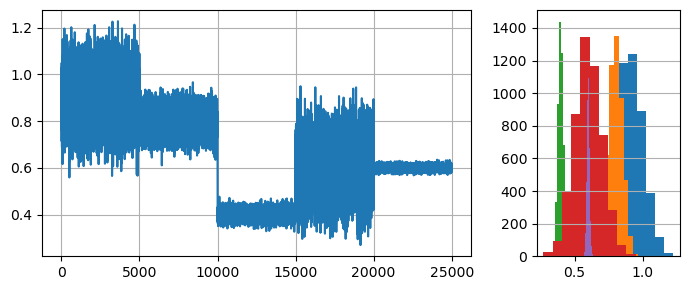

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Generamos datos para las 5 distribuciones
random_state = np.random.RandomState(seed=41)
dist_a = random_state.normal(0.9, 0.1, 5000)
dist_b = random_state.normal(0.8, 0.05, 5000)
dist_c = random_state.normal(0.4, 0.02, 5000)
dist_d = random_state.normal(0.6, 0.1, 5000)
dist_e = random_state.normal(0.6, 0.01, 5000)

# Creamos nuestra secuencia de datos
stream = np.concatenate((dist_a, dist_b, dist_c, dist_d, dist_e))

# Funciones auxiliares para analizar los datos
def plot_data(stream, dists, drifts=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    ax1.plot(stream, label='Stream')
    ax2.grid(axis='y')
    for id, dist in enumerate(dists):
        ax2.hist(dist, label=f'dist_{id}')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')
    plt.show()

plot_data(stream, [dist_a, dist_b, dist_c, dist_d, dist_e])


Emplearemos en este ejemplo  un detector de *concept drift* llamado *Adaptative WINdowing* ([ADWIN](https://riverml.xyz/latest/api/drift/ADWIN/)). El objetivo de este método es determinar cuándo ocurre un cambio en las propiedades estadísticas de los datos obtenidos a través de la secuencia empleando una ventana móvil  que se adapta a las diferentes variaciones (puede detectar variaciones a diferentes escalas).

**Nota**: veremos el detector ADWIN en la teoría de la materia.

El detector se basa en una ventana móvil que monitoriza estadísticas de los datos entrantes y detecta cambios en su distribución a lo largo del tiempo. El algoritmo mantiene dos conjuntos de estadísticas: las estadísticas de la ventana actual y las estadísticas de los datos históricos. Cuando se detecta un cambio en la distribución, la ventana actual se actualiza y los datos históricos se olvidan. El tamaño de la ventana se ajusta adaptativamente en función cómo evolucionan los datos. El algoritmo ADWIN es computacionalmente eficiente, con una complejidad temporal de $O(log n)$.

Change detected at index 5151

Change detected at index 10047

Change detected at index 15039

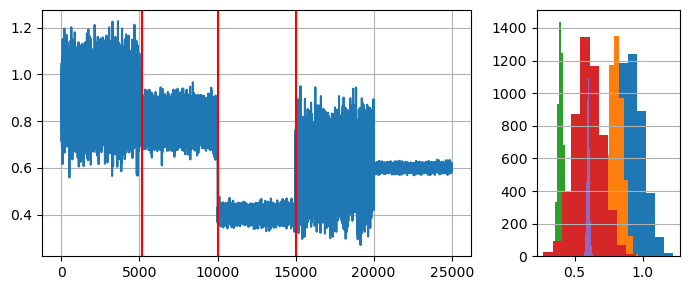

In [11]:
from river import drift

drift_detector = drift.ADWIN()
drifts = []

for i, val in enumerate(stream):
    drift_detector.update(val)   # Las observaciones se procesas una a una
    if drift_detector.drift_detected:
        # El detector indica la presencia de un drift después de procesar cada observación
        print(f'Change detected at index {i}')
        drifts.append(i)


#Muestra gráficamente los drifts detectados
plot_data(stream, [dist_a, dist_b, dist_c, dist_d, dist_e], drifts)


Como podemos observar, este método ha identificado 3 de las 4 derivas abruptas. En caso de que las derivas fuese graduales sería necesario una ventana más grande  y, por lo tanto, más pasos/observaciones  para identificar ese cambio. En este caso particular, necesitaría casi 500 muestras para percibir el cambio en los datos si es gradual.

¿Por qué el detector no ha generado una alarma en el último cambio (en la observación 20.000)? La respuesta es porque no es *concept drift* (aunque lo parezca). El promedio de los datos de entrada es el mismo, por lo que *ADWIN* no considera que haya un cambio en la distribución de los datos.

Es importante destacar que, típicamente, los detectors de *concept drift* se emplean para datos univariados y esa es la razón para que suelen emplearse para monitorizar el rendimiento del modelo y no los datos en sí.



#### EJERCICIO 1 PARA ENTREGAR EN EL AULA VIRTUAL

Existen otros detectores que pueden emplearse a través de River. En particular los dos siguientes pueden emplearse con este *dataset*


- [The Kolmogorov-Smirnov Windowing (KSWIN) method](https://riverml.xyz/latest/api/drift/KSWIN/)
- [The Page-Hinkley method](https://riverml.xyz/latest/api/drift/PageHinkley)


Implementa una prueba con los 2 detectores

**Nota**: tened cuidado porque KSWIN, ya que es muy sensible al parámetro alpha. Buscad un valor para ese parámetro apropiado.

In [13]:
###EJERCICIO 1 PARA ENTREGAR EN EL AULA VIRTUAL




### 2.1. *Concept drift* basado en el ratio de errores del modelo


Existen otros métodos de detección de *concept drift* que se basan en el análisis del ratio de errores del modelo.
En un escenario en el que la distribución de los datos y sus relaciones sea estacionaria,  la tasa de errores de un modelo debería disminuir a medida que aumenta el número de observaciones analizadas. Teniendo en cuenta esto, si el detector detecta un  aumento en la tasa de error o que este excede un cierto umbral, se activa una advertencia o una alarma.

Dado que estos métodos se basan en la tasa de error, podemos simular una secuencia de resultados de predicción, donde '1' significa que el modelo falló y '0' que el modelo tuvo éxito. En un problema del mundo real, esta información se obtendría directamente de los resultados del modelo una vez que recibe la etiqueta verdadera.

El siguiente ejemplo simula una secuencia de aciertos/errores para probar el DDM, que forma parte de los llamados detectores binarios en River.

El detector DDM tiene dos umbrales:  una vez que el flujo de resultados excede el primer umbral, el algoritmo advertirá (*warning*) al usuario de que posiblemente ocurra un *drift* en el futuro cercano (zona de advertencia). Una vez que se supera el segundo umbral, el algoritmo confirma el *drift* y restablece su memoria para continuar detectando nuevos cambios.

In [16]:
#Simulamos una caida de la precisión del modelo a lo largo del tiempo. Generamos 2 drifts abruptos
import random 
random.seed(1234)
#genera una lista de 1000 elementos, donde cada elemento es un 0 o un 1, elegidos al azar 
#El número 0 tiene una probabilidad del 80% (0.8) de ser elegido.
#El número 1 tiene una probabilidad del 20% (0.2) de ser elegido.
good_results=random.choices([0,1],  weights=[0.8, 0.2], k=1000) 
bad_results1=random.choices([0,1], weights=[0.6, 0.4], k=1000)#The elements from the list are chosen with different probability
bad_results2=random.choices([0,1], weights=[0.2, 0.8], k=1000)
data_stream=good_results+bad_results1+bad_results2


In [17]:
from river import drift
ddm=drift.binary.DDM(warm_start=100)#esperamos 100 observaciones antes de empezar a analizar el concept drift

#Simulamos un flujo con un bucle
trigger_warning=True
for idx, result in enumerate(data_stream):
    ddm.update(result)
    if ddm.warning_detected and trigger_warning:
        print(f"Warning detected at index {idx}")
        trigger_warning=False#Una vez que el umbral es sobrepasado, suele sobrepasarse durante muchas iteraciones
    if ddm.drift_detected:
        print(f"A drift was detected at index {idx}")
        trigger_warning=True
    



Warning detected at index 1077

A drift was detected at index 1151

Warning detected at index 1720

A drift was detected at index 2058

#### EJERCICIO 2 PARA ENTREGAR EN EL AULA VIRTUAL

Existen otros 3 detectores binarios (centrados en el ratio de errores del modelo) en River que deberás analzar y probar con los datos generados previamente.


- [EDDM](https://riverml.xyz/latest/api/drift/binary/EDDM/)
- [HDDM_A](https://riverml.xyz/latest/api/drift/binary/HDDM-A/)
- [HDDM_W](https://riverml.xyz/latest/api/drift/binary/HDDM-W/)

Fijaos que las interfaces de los métodos son iguales, por lo que podéis reutilizar el código pero, sin embargo,  los detectores se basan en hiperparámetros, por lo que sus configuraciones predeterminadas podrían no ser las óptimas para el problema y debáis de optimizarlos.

Los parámetros para inicializar los detectores también son diferentes. Debéis de consultar la documentación e iniciazarlos de forma apropiada





In [ ]:
#### EJERCICIO 2 PARA ENTREGAR EN EL AULA VIRTUAL




